## Плугатирьов Дмитро ІП-15

# Комп'ютерний практикум №1

## Залежності

In [3734]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Налаштування виводу на екран

In [3735]:
def plot_histogram(values: np.ndarray, bins: int, title: str, color: str = 'blue') -> plt.Axes:
    _, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.set_xlabel('Значення')
    ax.set_ylabel('Частота')
    ax.grid(True)
    ax.hist(values, bins=bins, color=color)
    return ax

def format_mean_std(mean_std: tuple, title):
    mean, std = mean_std
    return f'{title}: \nСереднє: {mean:.3f}, Std: {std:.3f}'

def format_chi2_info(chi2, chi2_k, title):
    return f'{title}: \nChi^2: {chi2:.3f}, Chi^2 k: {chi2_k}'

## Обчислення значень

In [3736]:
def get_sturges_bin_count(sample_size: int) -> int:
    """Розраховує оптимальну кількість інтервалів за правилом Стерджеса."""
    return math.ceil(math.log2(sample_size) + 1)

def get_bin_intervals(bin_edges : np.ndarray) -> list[tuple[float, float]]:
    """Перетворює масив меж [0, 5, 10] на пари [(0, 5), (5, 10)]."""
    return list(zip(bin_edges[:-1], bin_edges[1:]))

def calculate_sample_stats(data: np.ndarray) -> tuple[float, float]:
    """Повертає середнє (mean) та стандартне відхилення (std) вибірки."""
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    return (mean, std)

# Chi2 з таблиці (заздалегідь визначена) (функція відсоткової точки - ppf)
def get_chi2_critical_value(alpha: float, num_bins: int, num_params: int) -> float:
    """
    Повертає критичне значення з таблиці розподілу.
    df (degrees of freedom) = кількість інтервалів - кількість оцінених параметрів - 1
    """
    degrees_of_freedom = num_bins - num_params - 1
    return stats.chi2.ppf(1 - alpha, df=degrees_of_freedom)

def calculate_chi2_statistic(
    sample_size: int, 
    observed_counts: np.ndarray, 
    bin_edges: np.ndarray, 
    probability_func: callable, 
    *dist_params
    ) -> float:
    intervals = zip(bin_edges[:-1], bin_edges[1:])
    expected_probs = np.array([probability_func(l, r, *dist_params) for l, r in intervals])

    expected_counts = sample_size * expected_probs
    # Захист від ділення на 0 (хоча при рівноймовірних інтервалах це малоймовірно)
    expected_counts[expected_counts == 0] = 1e-10
    
    chi2 = np.sum(np.square(observed_counts - expected_counts) / expected_counts)
    return chi2

def is_hypothesis_accepted(chi2_stat: float, critical_value: float) -> bool:
    return chi2_stat <= critical_value

# Експоненційний закон розподілу

## Побудова графіку для перевірки закону


>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 0.5
Оцінене lambda: 0.5035 (Задане: 0.5)
Chi2 статистика: 5.2076
Критичне значення (df=7): 14.0700
✅ Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=0.5): 
Середнє: 1.986, Std: 1.993

>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 1.0
Оцінене lambda: 1.0038 (Задане: 1.0)
Chi2 статистика: 10.6803
Критичне значення (df=9): 16.9200
✅ Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=1.0): 
Середнє: 0.996, Std: 1.006

>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 2.5
Оцінене lambda: 2.5300 (Задане: 2.5)
Chi2 статистика: 22.3898
Критичне значення (df=12): 21.0300
❌ Результат: Закон ВІДХИЛЕНО
Експоненціальний (λ=2.5): 
Середнє: 0.395, Std: 0.394

>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 5.0
Оцінене lambda: 5.0411 (Задане: 5.0)
Chi2 статистика: 11.1491
Критичне значення (df=9): 16.9200
✅ Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=5.0): 
Середнє: 0.198, Std: 0.201


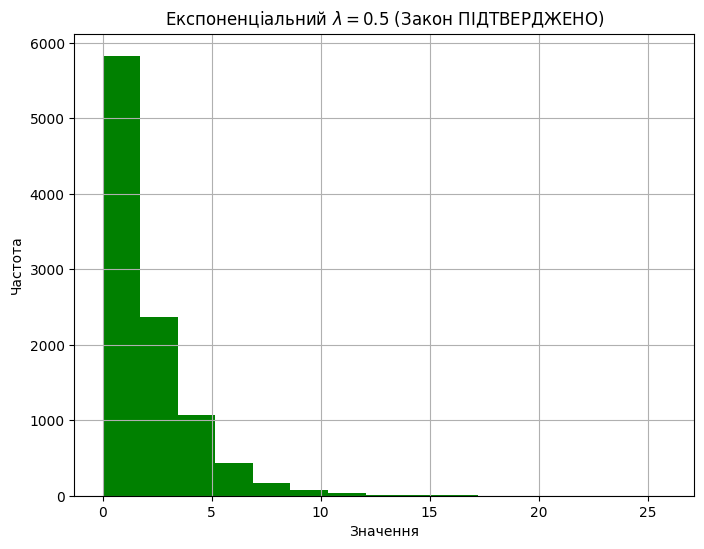

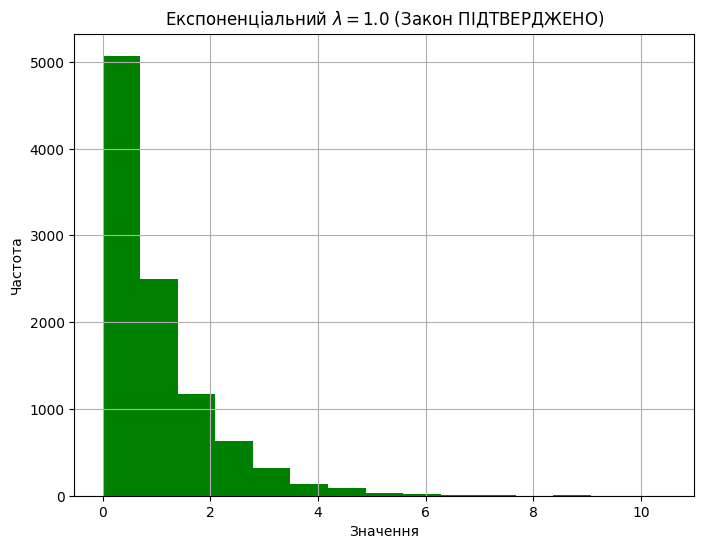

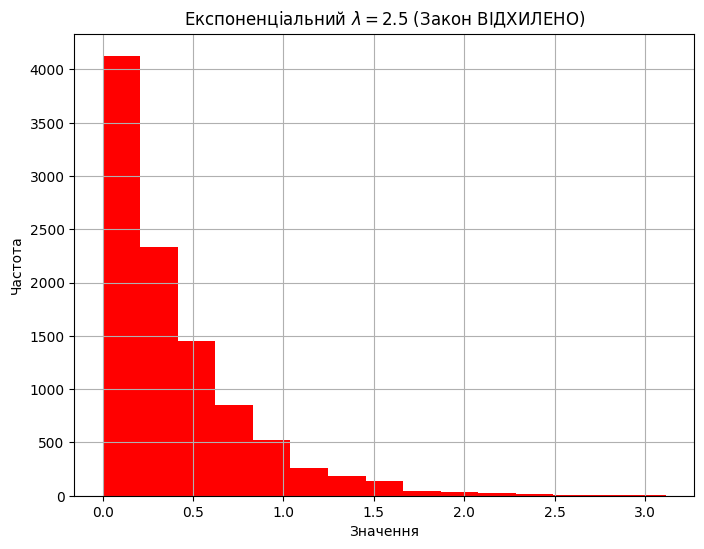

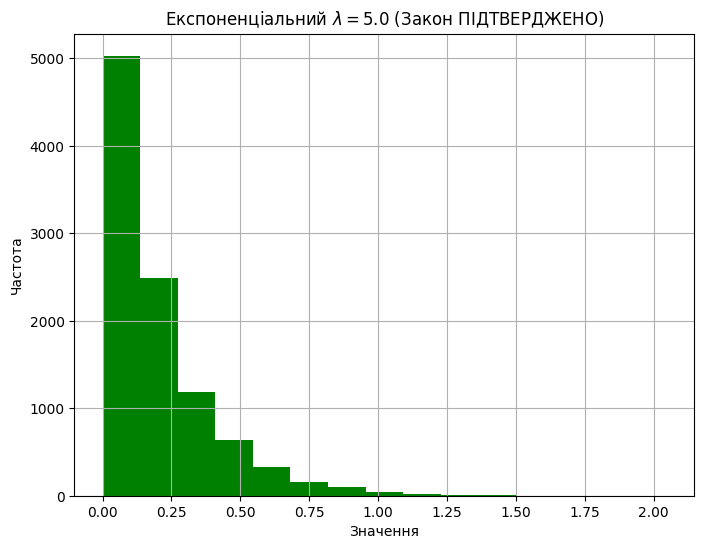

In [3737]:
import numpy as np
import matplotlib.pyplot as plt

# 1. ФУНКЦІЯ ПЕРЕВІРКИ (Об'єднує генерацію та тест)
def test_exponential_hypothesis(target_lambda, sample_size):
    print("\n" + "="*50)
    print(f">>> ТЕСТУВАННЯ ДЛЯ LAMBDA = {target_lambda}")
    print("="*50)

    # --- А. Генерація вибірки (Формула з завдання) ---
    uniform_samples = np.random.uniform(size=sample_size)
    exponential_samples = -1 / target_lambda * np.log(uniform_samples)

    # Розрахунок кількості бінів (правило Стерджеса або корінь)
    # Якщо у вас немає функції get_sturges_bin_count, розкоментуйте рядок нижче:
    # num_bins = int(np.log2(sample_size) + 1) 
    num_bins = get_sturges_bin_count(sample_size) 

    # --- Б. Отримання гістограми та оцінка параметрів ---
    observed_counts, bin_edges = np.histogram(exponential_samples, bins=num_bins)
    
    # Оцінюємо лямбда з вибірки (для чистоти експерименту)
    # Хоча ми знаємо target_lambda, тест Хі-квадрат зазвичай використовує оцінений параметр
    estimated_lambda = 1 / np.mean(exponential_samples)
    n_samples = len(exponential_samples)
    
    # --- В. Розрахунок теоретичних частот ---
    raw_expected = []
    for i in range(len(bin_edges) - 1):
        a = bin_edges[i]
        b = bin_edges[i+1]
        # P(a <= X < b) = exp(-lam*a) - exp(-lam*b)
        prob = np.exp(-estimated_lambda * a) - np.exp(-estimated_lambda * b)
        raw_expected.append(prob * n_samples)

    # --- Г. Об'єднання малих інтервалів (Ваш алгоритм) ---
    final_obs = []
    final_exp = []
    current_o = 0
    current_e = 0

    for o, e in zip(observed_counts, raw_expected):
        current_o += o
        current_e += e
        if current_e >= 5:
            final_obs.append(current_o)
            final_exp.append(current_e)
            current_o = 0
            current_e = 0
            
    if current_e > 0:
        if len(final_exp) > 0:
            final_obs[-1] += current_o
            final_exp[-1] += current_e
        else:
            final_obs.append(current_o)
            final_exp.append(current_e)

    final_obs = np.array(final_obs)
    final_exp = np.array(final_exp)

    # --- Д. Розрахунок статистики Хі-квадрат ---
    chi2_stat = np.sum((final_obs - final_exp)**2 / final_exp)
    df = len(final_obs) - 1 - 1 # (кількість груп - 1 - кількість параметрів)

    # --- Е. Критичне значення ---
    critical_values_table = {
        1: 3.84, 2: 5.99, 3: 7.81, 4: 9.49, 5: 11.07,
        6: 12.59, 7: 14.07, 8: 15.51, 9: 16.92, 10: 18.31,
        11: 19.68, 12: 21.03, 13: 22.36, 14: 23.68, 15: 25.00
    }
    limit = critical_values_table.get(df, df + 2 * (2*df)**0.5)

    # --- Є. Вивід результатів ---
    print(f"Оцінене lambda: {estimated_lambda:.4f} (Задане: {target_lambda})")
    print(f"Chi2 статистика: {chi2_stat:.4f}")
    print(f"Критичне значення (df={df}): {limit:.4f}")
    
    status_icon = "✅" if chi2_stat < limit else "❌"
    result_msg = "Закон ПІДТВЕРДЖЕНО" if chi2_stat < limit else "Закон ВІДХИЛЕНО"
    print(f"{status_icon} Результат: {result_msg}")

    # Виклик ваших функцій для статистики (якщо вони визначені)
    try:
        estats = calculate_sample_stats(exponential_samples)
        print(format_mean_std(estats, f'Експоненціальний (λ={target_lambda})'))
    except NameError:
        pass # Ігноруємо, якщо функції не знайдено

    # --- Ж. Побудова графіка ---
    plot_title = f'Експоненціальний $\lambda={target_lambda}$ ({result_msg})'
    plot_histogram(
        exponential_samples, 
        num_bins, 
        title=plot_title, 
        color='green' if chi2_stat < limit else 'red'
    )

# ==========================================
# 2. ГОЛОВНИЙ ЦИКЛ (Виконання завдання)
# ==========================================

sample_size_global = 10000 
# Список різних лямбда для перевірки, як вимагає завдання
lambda_values_to_test = [0.5, 1.0, 2.5, 5.0]

for lam in lambda_values_to_test:
    test_exponential_hypothesis(target_lambda=lam, sample_size=sample_size_global)

# Нормальний закон розподілу

## Налаштування графіку гістограми

In [3738]:
sample_size = 10000
normal_init_bins = get_sturges_bin_count(sample_size)
print('Стовпці для гістограми нормального розподілу:', num_bins)

Стовпці для гістограми нормального розподілу: 15


## Формулювання закону розподілу

In [3739]:
sigma = 4 # Стандартне відхилення (scale)
multiplier_a = -5 # Математичне сподівання (loc)

# 1. Генерація матриці (N x 12) випадкових чисел
uniform_matrix = np.random.uniform(size=(sample_size, 12))

# 2. Отримання стандартного нормального розподілу N(0, 1)
# Згідно з центральною граничною теоремою: сума 12 рівномірних - 6 ≈ N(0, 1)
standard_normals = uniform_matrix.sum(axis=1) - 6

# 3. Трансформація до N(mean, sigma)
# Формула: X = sigma * Z + mean
normal_data = sigma * standard_normals + multiplier_a

print(normal_data)

# normal_law = np.zeros(sample_size)
# for idx in range(sample_size):
#     mu_value = np.random.uniform(size=12).sum() - 6
#     normal_law[idx] = sigma * mu_value + target_mean
# normal_law

[-14.11590903  -4.5565106   -5.53991997 ...  -2.86300919 -12.68165028
   2.24676407]


## Побудова графіку для перевірки закону

<Axes: title={'center': 'Закон - Нормальний розподіл'}, xlabel='Значення', ylabel='Частота'>

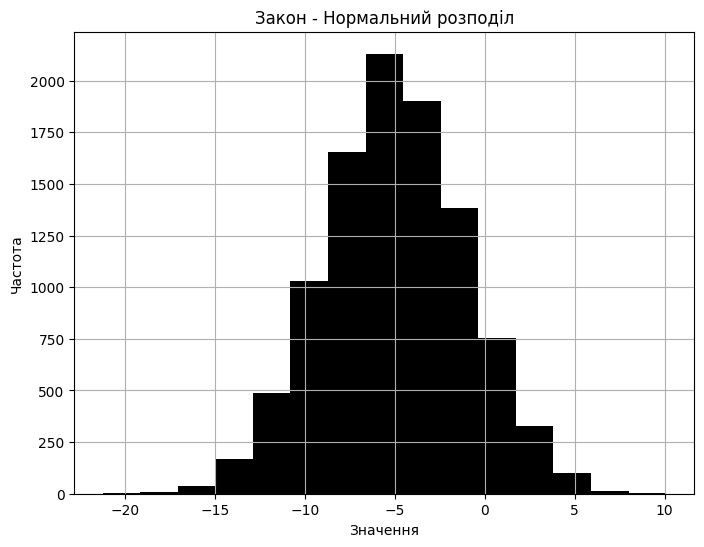

In [3740]:
observed_counts, bin_edges = np.histogram(normal_data, bins=normal_init_bins)
plot_histogram(
  normal_data, 
  bin_edges, 
  title='Закон - Нормальний розподіл', 
  color='black'
  )

## Статистика за законом

In [3741]:
sample_stats = calculate_sample_stats(normal_data)
sample_mean, sample_std = sample_stats
formatted_chi2 = format_mean_std(sample_stats, 'Нормальний розподіл')
print(formatted_chi2)

Нормальний розподіл: 
Середнє: -4.995, Std: 3.931


## Перевірка за критерієм згоди xi^2

In [3742]:
# Кумулятивна функція розподілу - cdf
def prob_normal(left: float, right: float, mean_val: float, std_val: float) -> float:
    """
    Розраховує площу під кривою Гауса між двома точками.
    loc = середнє (mean), scale = стандартне відхилення (std).
    """
    cdf_values = stats.norm.cdf([left, right], loc=mean_val, scale=std_val)
    return cdf_values[1] - cdf_values[0]

estimated_mean = sample_mean
estimated_std = sample_std
chi2 = calculate_chi2_statistic(
    sample_size, 
    observed_counts, 
    bin_edges, 
    prob_normal, 
    estimated_mean, 
    estimated_std
    )

critical_value = get_chi2_critical_value(0.05, normal_init_bins, 2)
formatted_chi2 = format_chi2_info(chi2, critical_value, 'Нормальний розподіл')
print(formatted_chi2)

Нормальний розподіл: 
Chi^2: 9.256, Chi^2 k: 21.02606981748307


In [3743]:
if is_hypothesis_accepted(chi2, critical_value):
    print("Закон нормального розподілу працює!")
else:
    print("Закон нормального розподілу не працює!")

Закон нормального розподілу працює!


# Рівномірний закон розподілу

## Конфігурація графіку гістограми

In [3744]:
sample_size = 10000
num_bins = get_sturges_bin_count(sample_size)
print('Кількість інтервалів для Рівномірного розподілу:', num_bins)

Кількість інтервалів для Рівномірного розподілу: 15


## Формуляція закону розподілу

In [3745]:
multiplier_a = 5**13
modulus_m = 2**31
zi_value = np.random.uniform()

# Початкове значення (Seed / X_0)
# LCG працює з цілими числами, тому перетворюємо початковий float на int
current_x = int(np.random.uniform(1, modulus_m))

uniform_data = np.zeros(sample_size)

for i in range(sample_size):
    current_x = (multiplier_a * current_x) % modulus_m
    uniform_data[i] = current_x / modulus_m

print(uniform_data)


[0.94590046 0.50051959 0.9151224  ... 0.37110718 0.3874947  0.97320218]


## Побудова графіку для перевірки закону

<Axes: title={'center': 'Закон - Рівномірний розподіл'}, xlabel='Значення', ylabel='Частота'>

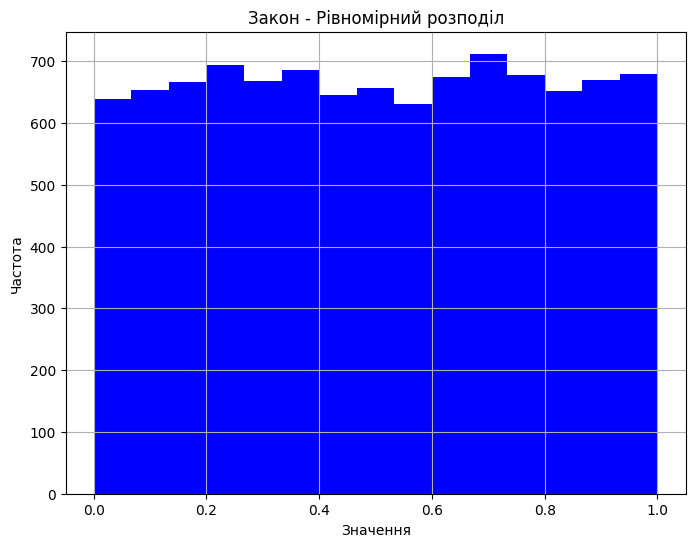

In [3746]:
uniform_counts, uniform_bins = np.histogram(uniform_data, bins=num_bins)
plot_histogram(uniform_data, uniform_bins, title='Закон - Рівномірний розподіл', color='blue')

## Статистика за законом

In [3747]:
uniform_stats = calculate_sample_stats(uniform_data)
uniform_mean, uniform_std = uniform_stats
formatted_chi2 = format_mean_std(uniform_stats, 'Рівномірний розподіл')
print(formatted_chi2)

Рівномірний розподіл: 
Середнє: 0.503, Std: 0.288


## Перевірка за критерієм згоди xi^2

In [3748]:
def prob_uniform(left: float, right: float, lower_bound: float, upper_bound: float) -> float:
    """
    Розраховує ймовірність потрапляння в інтервал.
    PDF = 1 / (upper - lower).
    Ймовірність = Ширина_інтервалу * PDF.
    """
    l = max(left, lower_bound)
    r = min(right, upper_bound)
    
    if l >= r:
        return 0.0

    return (r - l) / (upper_bound - lower_bound)

estimated_lower = uniform_mean - 3 ** 0.5 * uniform_std
estimated_upper = uniform_mean + 3 ** 0.5 * uniform_std
chi2 = calculate_chi2_statistic(sample_size, uniform_counts, uniform_bins,
                            prob_uniform, estimated_lower, estimated_upper)
critical_value = get_chi2_critical_value(0.05, num_bins, 2)
formatted_chi2 = format_chi2_info(chi2, critical_value, 'Рівномірний розподіл')
print(formatted_chi2)

Рівномірний розподіл: 
Chi^2: 8.490, Chi^2 k: 21.02606981748307


In [3749]:
if is_hypothesis_accepted(chi2, critical_value):
    print("Закон рівномірного розподілу працює!")
else:
    print("Закон рівномірного розподілу не працює!")

Закон рівномірного розподілу працює!
